In [2]:
#-- Loading: Training Dataset.

fids = glob('./weather_data/*csv'); fids.sort()
df = pd.DataFrame()
#-- Selected Columns.
#-- The reason why the training dataset only select the vars below is because
#--     1. They are common vars happened in the dataset among years
#--     2. But elimite the 'EVAP' because the numbers of nan value is varied. 
jointCols=['Lat', 'Lon', 'AWND', 'PRCP', 'SNOW', 'SNWD', 
           'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'WT01', 'WT02', 
           'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT11', 'date']
for fid in fids:
    year = fid.split('/')[2].split('_')[0]
    if int(year) >= 1992 and int(year) <=2015:
        dd = pd.read_csv(fid,header=0)
        dd['date'] = pd.to_datetime(year+ dd.month.astype('str'), format='%Y%m')  
        df = df.append(dd[jointCols])

df = df.set_index('date')
df.index = df.index.strftime('%Y-%m')        

In [3]:
#-- Loading: Target Dataset.
conn = sqlite3.connect('./FPA_FOD_20170508.sqlite')
query = "SELECT * From Fires"
target= pd.read_sql_query(query, conn)

In [4]:
target = target[target['STATE'] == 'CA']
target = target[['DISCOVERY_DOY',
                 'DISCOVERY_DATE',
                 'LATITUDE',
                 'LONGITUDE',
                 'FIRE_YEAR',
                 'FIRE_SIZE_CLASS',
                 'STAT_CAUSE_DESCR']].drop_duplicates().dropna()
target = target.rename(columns={'DISCOVERY_DATE': 'DISCOVERY_DATE_julian'})
target['DISCOVERY_DATE'] = pd.to_datetime(target['DISCOVERY_DATE_julian'] - pd.Timestamp(0).to_julian_date(), unit='D')
target = target.groupby([pd.Grouper(key='DISCOVERY_DATE', freq='1M'),pd.Grouper(key='FIRE_SIZE_CLASS')]).size().unstack(level=1).fillna(0)
target.index = target.index.strftime('%Y-%m')    
target = target.loc['1992-01':'2015-12']

In [5]:
#-- Train/Target : np.array()
train = [ df.loc[date].values for date in np.unique(df.index.values)]    
x_train, x_test, y_train, y_test = train_test_split(train, target.values, test_size=0.3, random_state=42)

In [6]:
#--- Hidden Layer's Node by Empirical calculation.
print('Empirical Nodes: [{:f}, {:f}]'.format(np.sqrt(20*7), np.sqrt(2*(7+1)*201)))

Empirical Nodes: [11.832160, 56.709788]


---
---
**Random Forest Regression**. 

In [7]:
## x_train, x_test, y_train, y_test = train_test_split(train, target.values, test_size=0.3, random_state=42)


In [8]:
regressor = RandomForestRegressor(n_estimators = 1000, 
                                  random_state = 0, 
                                  n_jobs=-1,
                                  verbose=1)
regressor.fit(np.array(x_train).reshape(201,-1), np.array(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.9min finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0, verbose=1)

In [9]:
# Predicting the Test set results
y_pred = regressor.predict(np.array(x_test).reshape(87,-1))

# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


Mean Absolute Error: 21.579259441707723
Mean Squared Error: 2892.727291082102
Root Mean Squared Error: 53.78408027550626


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


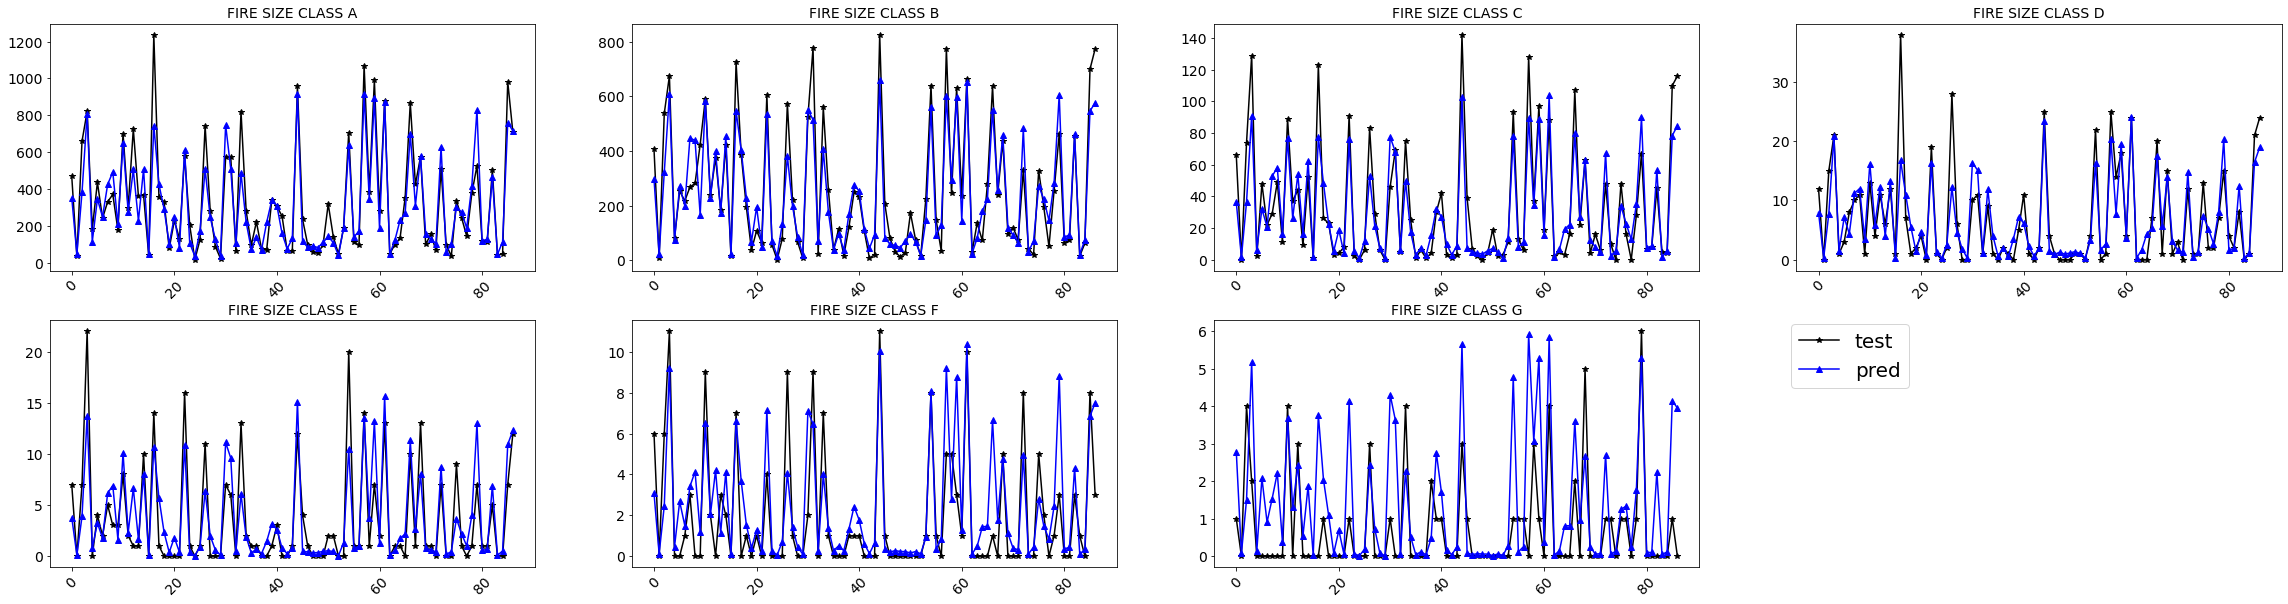

In [10]:
columns=['A','B','C','D','E','F','G']
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(40,10))
for num, ax in enumerate(axes.flat):
    if num < 7:
        yt,yd = y_test[:,num], y_pred[:,num]
        ax.plot(yt,'k-*')
        ax.plot(yd,'b-^')
        ax.set_title('FIRE SIZE CLASS '+columns[num],fontsize=14)
        ax.tick_params('x', labelrotation=45, labelsize=14)
        ax.tick_params('y',labelsize=14)
    else: ax.axis('off')

fig.legend(['test', 'pred'], loc='lower center', 
           bbox_to_anchor = (0.25,0.36,1,1), 
           bbox_transform = plt.gcf().transFigure,
           fontsize=20,
          )

---
---
**Random Forest Regression**.  Spatial Distribution Average

In [11]:
regressor_ave_spatial = RandomForestRegressor(n_estimators = 1000, 
                                              random_state = 0, 
                                              n_jobs=-1,
                                              verbose=1)
regressor_ave_spatial.fit(np.mean(x_train,axis=1), y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0, verbose=1)

In [12]:
# Predicting the Test set results
y_pred = regressor_ave_spatial.predict(np.mean(x_test,axis=1))

# Evaluating the Algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


Mean Absolute Error: 22.1633382594417
Mean Squared Error: 3135.157325587848
Root Mean Squared Error: 55.99247561581688


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


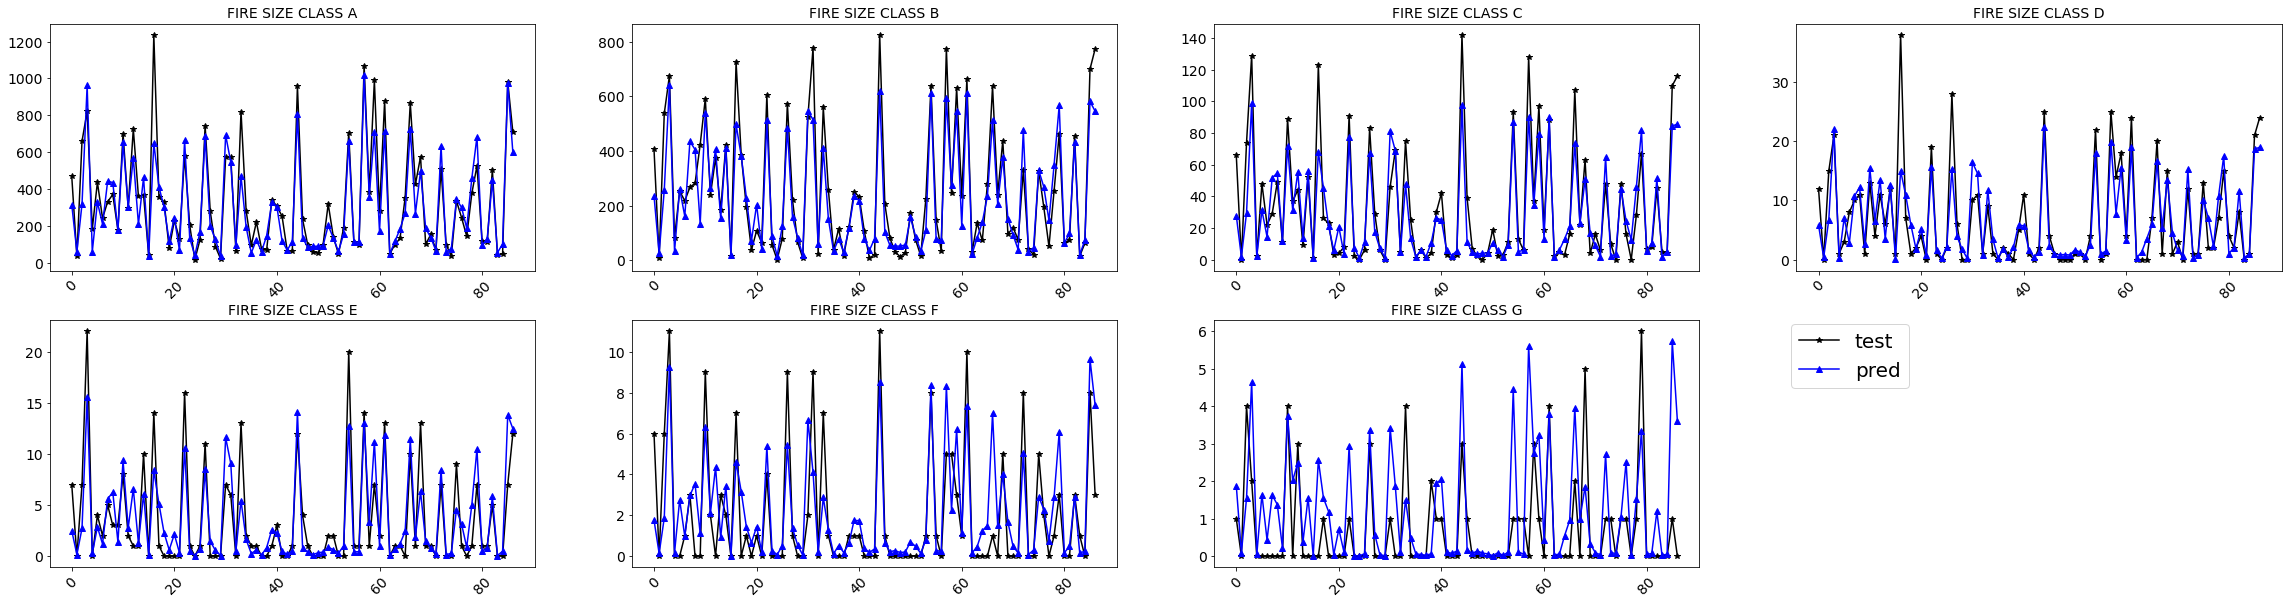

In [13]:
columns=['A','B','C','D','E','F','G']
fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(40,10))
for num, ax in enumerate(axes.flat):
    if num < 7:
        yt,yd = y_test[:,num], y_pred[:,num]
        ax.plot(yt,'k-*')
        ax.plot(yd,'b-^')
        ax.set_title('FIRE SIZE CLASS '+columns[num],fontsize=14)
        ax.tick_params('x', labelrotation=45, labelsize=14)
        ax.tick_params('y',labelsize=14)
    else: ax.axis('off')

fig.legend(['test', 'pred'], loc='lower center', 
           bbox_to_anchor = (0.25,0.36,1,1), 
           bbox_transform = plt.gcf().transFigure,
           fontsize=20,
          )